In [1]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
from statsmodels.tsa.stattools import coint
import requests
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import datetime as dt
import pandas_datareader as web
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

In [2]:
start = dt.datetime(2017, 1, 1)
end = dt.datetime.now()

crypto_assets = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'XRP-USD', 'SOL1-USD', 'LUNA1-USD', 'DOGE-USD', 'SHIB-USD', 'ADA-USD', 'LINK-USD', 'AVAX-USD', 'MATIC-USD', 'SUSHI-USD', 'ALGO-USD']
currency_assets = ['EURUSD=X', 'GBPUSD=X', 'JPY=X', 'AUDUSD=X', 'CAD=X', 'CHF=X', 'CNY=X']

assetsDF = pd.DataFrame()

for asset in crypto_assets + currency_assets:
    ticker = yf.Ticker(asset)
    data = ticker.history(start=start, end=end)
    data['Symbol'] = asset
    assetsDF = pd.concat([assetsDF, data])

assetsDF = assetsDF.dropna()
assetsDF
assetsDF = assetsDF.reset_index()

In [3]:
fig = px.line(assetsDF, x='Date', y='Close', color='Symbol', title='Close Price of Crypto and Currency Assets from 2017 to Present')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.show()

In [4]:
assetsDF.head()

Date         Open         High          Low        Close     Volume  \
0 2017-01-01   963.658020  1003.080017   958.698975   998.325012  147775008   
1 2017-01-02   998.617004  1031.390015   996.702026  1021.750000  222184992   
2 2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  185168000   
3 2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  344945984   
4 2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  510199008   

   Dividends  Stock Splits   Symbol  
0          0             0  BTC-USD  
1          0             0  BTC-USD  
2          0             0  BTC-USD  
3          0             0  BTC-USD  
4          0             0  BTC-USD

As seen above it is often difficult to determine any relationships between different financial assets and cryptocurrencies using the adjusted closing prices. Instead of using prices, the log returns will be used to normalize the data such that all variables are in a comparable metric. This will enable the evaluation of analytic relationships of several cryptocurrencies despite them originating from price series of unequal values.

Assuming that the prices for the above cryptocurrencies are distributed log-normally or approximately log-normally, then the log return is likely normally distributed.

$$ r_t = log(1 + R_t) = log \frac {P_t}{P_{t−1}} = log(p_t) − log(p_{t−1})  $$

For further details see: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [5]:
import numpy as np

# calculate the log returns for each asset
log_returns = assetsDF[['Date', 'Symbol', 'Close']].pivot(index='Date', columns='Symbol', values='Close').pct_change().apply(lambda x: np.log(1+x))

# drop the first row, which contains NaN values
log_returns = log_returns.drop(log_returns.index[0])

# reset the index and rename the columns
log_returns = log_returns.reset_index().rename_axis(None, axis=1)

# Drops NaN
log_returns = log_returns.dropna()
log_returns

Date   ADA-USD  ALGO-USD  AUDUSD=X  AVAX-USD   BNB-USD   BTC-USD  \
1723 2021-09-21 -0.038000 -0.046903 -0.000593  0.040447 -0.049356 -0.051488   
1724 2021-09-22  0.131456  0.156756 -0.004377  0.228758  0.096503  0.068400   
1725 2021-09-23  0.028176  0.085094  0.000830  0.029643  0.011477  0.029856   
1726 2021-09-24 -0.021540 -0.114531  0.009055 -0.054000 -0.077166 -0.046862   
1727 2021-09-25  0.008847 -0.031625  0.000000 -0.057128 -0.015418 -0.002879   
...         ...       ...       ...       ...       ...       ...       ...   
2265 2023-03-17  0.074426  0.082869  0.006791  0.105695  0.027568  0.090431   
2266 2023-03-18 -0.037239 -0.052225  0.000000 -0.038064 -0.022538 -0.016844   
2267 2023-03-19  0.024277  0.024458  0.000000  0.033330  0.016317  0.039013   
2268 2023-03-20 -0.039542 -0.050270  0.007448 -0.053942 -0.012107 -0.009728   
2269 2023-03-21  0.106029  0.065242 -0.005890  0.045111  0.008414  0.013489   

         CAD=X     CHF=X     CNY=X  ...     JPY=X  LINK-USD  LUNA1-USD  \
1723  0.003004 -0.004700 -0.000031  ... -0.004868 -0.089150  -0.078905   
1724  0.001436 -0.004505  0.000155  ... -0.002635  0.133476   0.279819   
1725 -0.002726  0.003027 -0.000805  ...  0.006147  0.038482   0.084366   
1726 -0.009738 -0.001945 -0.000449  ...  0.004579 -0.089246   0.104768   
1727  0.000000  0.000000  0.000000  ...  0.000000  0.052012  -0.058738   
...        ...       ...       ...  ...       ...       ...        ...   
2265 -0.003333 -0.002000 -0.001217  ...  0.003297  0.079303   0.000000   
2266  0.000000  0.000000  0.000000  ...  0.000000 -0.041224   0.000000   
2267  0.000000  0.000000  0.000000  ...  0.000000  0.024091   0.000000   
2268 -0.000678 -0.002619 -0.001654  ... -0.008161 -0.006341   0.000000   
2269  0.000226 -0.005649 -0.000523  ... -0.000023  0.046005   0.000000   

      MATIC-USD  SHIB-USD  SOL1-USD  SUSHI-USD  USDC-USD  USDT-USD   XRP-USD  
1723  -0.073171  0.000000  0.005086  -0.102632 -0.000040  0.000172 -0.045532  
1724   0.162118  0.000000  0.007279   0.129986 -0.000781 -0.000048  0.136081  
1725  -0.004526  0.133531 -0.011041   0.011023  0.000476  0.000468 -0.002030  
1726  -0.082176 -0.133531 -0.059897  -0.092955  0.000096  0.000312 -0.057631  
1727  -0.005892  0.000000 -0.010385  -0.016927  0.000204  0.000169 -0.004856  
...         ...       ...       ...        ...       ...       ...       ...  
2265   0.062121  0.000000  0.000000   0.071414  0.000084  0.000192  0.038474  
2266  -0.044152  0.000000  0.000000  -0.042837 -0.000543  0.000011 -0.015763  
2267  -0.002269  0.000000  0.000000   0.022903  0.000343  0.000668  0.036790  
2268  -0.057084 -0.095310  0.000000  -0.056220 -0.001867 -0.001214 -0.036269  
2269   0.043366  0.089719  0.000000  -0.000343  0.000351 -0.000412  0.217004  

[547 rows x 24 columns]

In [6]:
crypto = px.line(log_returns, x = "Date", y = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'XRP-USD', 'SOL1-USD', 'LUNA1-USD', 'DOGE-USD', 'SHIB-USD', 'ADA-USD', 'LINK-USD', 'AVAX-USD', 'MATIC-USD', 'SUSHI-USD', 'ALGO-USD'], title = "Log Return Time Series")
crypto.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
crypto.show()

## Correlation VS Cointegration

Although correlation and cointegration are similar there are some key differences between the two that will be explored below. 

### Correlation
Definition: Any statistical relationship, whether causal or not, between two random variables or bivariate data. The Correlation Coefficient or Pearson correlation coefficient is commonly obtained by taking the ratio of the covariance of the two variables in question from the numerical dataset, normalized to the square root of their variances. Mathematically, it is the division of the covariance (joint variability of two random variables) of the two variables by the product of their standard deviations.

$$ \rho X,Y = \text{corr(X,Y)} = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}  = \frac{E[(X-{\mu}x)(Y-{\mu}y)]}{\sigma_x \sigma_y}$$


$$ \text{cov}(X, Y) = E[(X - E[X])(Y - E[Y])]$$

For further details see: https://en.wikipedia.org/wiki/Correlation

### Cointegration
Definition: A test for non-stationary time series processes that have variances and means that vary over time. This method allows for estimating the long-run parameters or equilibrium in systems with unit root variables. If two or more series are individually integrated (in the time series sense) but some linear combination of them has a lower order of integration, then the series are said to be cointegrated.

In most cases when the individual series $Y_{1,t} \text{and} Y_{2,t}$ are non-stationary first-order integrated variables $I(1)$, a linear combination of these variables is also non-stationary. However, if there exists some (cointegrating) vector of coefficients that form a stationary linear combination of them it is said that the two series are cointegrated.

Consider the two series $Y_{1,t} \text{and} Y_{2,t}$ which are integrated of the first order, $I(1)$. Regressing these variables on one another creates the linear regression model: $u_t = Y_{1,t} - \beta_1Y_{2,t}$
If the error term $u_t$ is stationary, $I(0)$, then by definition the combined $Y_{1,t} - \beta_1Y_{2,t}$ must also be stationary. While both $Y_{1,t} \text{and} Y_{2,t}$ have distinct stochastic trends, the series $Y_{1,t} \text{and} Y_{2,t}$ are cointegrated as  the linear combination $Y_{1,t} - \beta_1Y_{2,t}$ has the statistical properties of an $I(0)$ series.

For further details see: https://hudsonthames.org/an-introduction-to-cointegration/

### Engle-Granger two-step method
The Engle-Granger is one of the most common tests used to measure cointegration. It constructs residual errors based on the statistic regress. The test checks the residuals for the presence of unit roots using an Augmented Dickey-Fuller test (ADF test). If the residuals are stationary the two-time series are said to be cointegrated. 

1. The first step of this method is to verify that the individual time series are non-stationary. This is done using the standard unit root test and ADF test. Both series must be non-stationary first-order integrated variables $I(1)$. Consider the two series $Y_{1,t} \text{and} Y_{2,t}$ which are integrated of the first order, $I(1)$. The following ECM model is estimated. ${\displaystyle A(L)\,\Delta y_{t}=\gamma +B(L)\,\Delta x_{t}+\alpha (y_{t-1}-\beta _{0}-\beta _{1}x_{t-1})+\nu _{t}.}$ If both variables are integrated and this ECM exists, they are cointegrated by the Engle–Granger representation theorem.
2. The second step of the Engle-Granger test is to estimate the model using the ordinary least squares (OLS) ${\displaystyle y_{t}=\beta _{0}+\beta _{1}x_{t}+\varepsilon _{t}}$. In the case the regression is not spurious as determined by the test criteria described the OLS will be valid and demonstrate a consistent estimator (converging in probability to the true value of the parameter). The estimated residuals ${\displaystyle {\hat {\varepsilon _{t}}}=y_{t}-\beta _{0}-\beta _{1}x_{t}}$ are saved and are used in a regression of differenced variables plus the lagged error term. ${\displaystyle A(L)\,\Delta y_{t}=\gamma +B(L)\,\Delta x_{t}+\alpha {\hat {\varepsilon }}_{t-1}+\nu _{t}.}$ From here the test for cointegration is completed using a standard t-statistic on $\alpha$. 
Where it follows that if ${\alpha}: \leq 0.05$  the two-time series are cointegrated.

This test will reject the null if the p-value < 0.05 in which case there is no need to find an order of differencing. If the p-value is > 0.05 then we would fail to reject the null and the series will require differencing operations to be performed until the time series is stationary. 


$\begin{eqnarray}
\Delta y_{1,t}&=& \gamma_{0} + \alpha_{1} \left[ y_{1,t-1}-\beta_1 y_{2,t-1} \right] + \ldots \sum_{i=1}^{K} \zeta_{1,i} \Delta y_{1,t-1} + \sum_{j=1}^{L} \zeta_{2,j} \Delta y_{2,t-1} + \varepsilon_{y_1,{t}} \\
\Delta y_{2,t} &=& \eta_{0} + \alpha_{2} \left[ y_{1,t-1}-\beta_1 y_{2,t-1} \right] + \ldots\sum_{i=1}^{K} \xi_{1,i} \Delta y_{2,t-1} + \sum_{j=1}^{L} \xi_{2,j} \Delta y_{1,t-1} + \varepsilon_{y_2,{t}}
\end{eqnarray}$

$\begin{eqnarray}
\Delta y_{1,t}&=& \gamma_{0} + \alpha_{1} \left[y_{1,t-1}-\beta_1 y_{2,t-1} \right]\end{eqnarray}$



#### Issues with the Engle-Granger Test 
1. The univariate unit root tests used in the first stage have low statistical power
2. The choice of the dependent variable in the first stage influences test results, i.e. we need weak exogeneity for $x_t$as determined by Granger causality
3. One can potentially have a small sample bias
4. The cointegration test on $\alpha$  does not follow a standard distribution
5. The validity of the long-run parameters in the first regression stage where one obtains the residuals cannot be verified because the distribution of the OLS estimator of the cointegrating vector is highly complicated and non-normal
6. At most one cointegrating relationship can be examined.

### Johansen Test
Many of the weaknesses of the Engle-Granger Test can be addressed by the Johansen Test which is a type of vector error correction model (VECM) that assesses the validity of cointegrating relationships using a maximum likelihood estimate (MLE) approach. The Johansen test seeks to test for cointegration in the multivariate case by determining the rank of $\Pi$ and determining the number of non-zero eigenvalues in $\Pi$. The Johansen Test proposes two methods for estimating the rank, one with the trace statistic and one with the maximum eigenvalue statistic. 

#### VAR
Consider a first order Vector Autoregression $VAR(1)$ for the $n\times1
$ vector $\boldsymbol{y}_{t}=[y_{1,t}, y_{2,t}, \ldots ,y_{n,t}]^{\prime}$ $$\begin{eqnarray}
\boldsymbol{y}_{t}=\mu+\Pi_{1} \boldsymbol{y}_{t-1}+\boldsymbol{u}_{t}
\end{eqnarray}$$
where $\mu=[\mu_{1} , \mu_{2}, \ldots ,\mu_{n}]^{\prime}$ is a vector of constants
$\boldsymbol{u}_{t}=[ u_{1,t},u_{2,t}, \ldots , u_{n,t}]^{\prime}$ is a vector of error terms
and $\Pi_{1}$ is a $(n \times n)$ matrix of coefficients
 
The stability of the VAR model is determined by the eigenvalues of $\Pi_{1}$ that are obtained by solving the characteristic equation $\begin{eqnarray}
| \; \Pi_{1}- I \; |=0
\end{eqnarray}$ where VAR is stable if all eigenvalues are modulus less than 1. 

Consider the example when $n = 2$. The bivariate VAR(1) is:
$$\begin{eqnarray*}
\left[
\begin{array}
[c]{c}%
y_{1,t}\\
y_{2,t}%
\end{array}
\right]  =\left[
\begin{array}
[c]{c}%
\mu_{1}\\
\mu_{2}%
\end{array}
\right]  +\left[
\begin{array}
[c]{cc}%
\pi_{1,1} & \pi_{1,2}\\
\pi_{2,1} & \pi_{2,2}
\end{array}
\right]  \left[
\begin{array}
[c]{c}%
y_{1,t-1}\\
y_{2,t-1}%
\end{array}
\right]  +\left[
\begin{array}
[c]{c}%
\varepsilon_{1,t}\\
\varepsilon_{2,t}%
\end{array}
\right]
\end{eqnarray*}
$$
If one or more of the eigenvalues has a modulus greater than or equal to 1 then the VAR is unstable and is nonstationary. Extending this concept to cointegration for multivariate VAR models requires the specification of the vector error correction model. 

#### VECM
Rewriting VAR(1) as a VECM by differencing the series yeilds: 
$$\begin{eqnarray} \nonumber
\Delta {\bf{y}}_{t}  & = & \mu+(\Pi_{1}-I){\bf{y}}_{t-1}+{\bf{u}}_{t} \\
& = & \mu+\Pi {\bf{y}}_{t-1}+{\bf{u}}_{t} \;\;\; \mathsf{where } \; \Pi=(\Pi_{1}-I)
\end{eqnarray}
$$ 

 
#### Hypotheses

With $n$ variables, the number of linear combinations of the variables in $\boldsymbol{y}_{t}$ that are stationary will provide the resulting number of cointegration vectors. 

1. $\Pi$ has full rank $n = r$ The VAR must be stable as there is no instability present in the system of equations. 
2. $\Pi$ has rank $1\leq r\leq n-1$ The number of linear combinations is smaller than the number of variables. Hence, some of the variables must be unstable and at least one combination of the variables is stable. The number of cointegrating vectors is given by $r$.
3. $\Pi$ has rank $r=0$ i.e. $\Pi = 0$ There is instability present and no combination of the variables is stable. The unstable VAR is unable to be cointegrated and should be estimated using the first differences. 


When $VAR(p)$ are cointegrated, then the VECM includes the long-run cointegration as well as the speed of adjustment parameters. $\Pi$ is then decomposed as $\begin{eqnarray*}
\Pi=\alpha\beta^{\prime}
 \end{eqnarray*}$ where $\alpha$ and $\beta$ are dimensions $n \times r$ $\beta$ is a matrix of cointegraion parameters, such that the linear combinations of $\beta^{\prime} {\bf{y}}_{t}$ are stationary. Each of the $r$ rows in $\beta^{\prime} {\bf{y}}_{t}$ is a cointegrated long-run relation inducing stability. $\alpha$ is a matrix that contains the speed of adjustmet parameters which accounts for the time it takes to move back to equilibrium.  

Considering the original bivariate case: 
$$\begin{eqnarray}
\left[\begin{array}{c}
\Delta y_{1,t}\\ \Delta y_{2,t}
\end{array}\right] =
\left[\begin{array}{c}
\mu_{1}\\ \mu_{2}
\end{array}\right] +
\left[\begin{array}{c}
\alpha_{1}\\ \alpha_{2}
\end{array}\right]
\Big[\beta_{1} \beta_{2}\Big] \left[\begin{array}{c}
y_{1,t-1}\\ y_{2,t-1}
\end{array} \right] +
\left[\begin{array}{c}
u_{1,t}\\ u_{2,t}
\end{array}\right]
\end{eqnarray}
$$

The cointegration relationship $\beta^{\prime} {\bf{y}}_{t}$ is given by:
$$\begin{eqnarray*}
\beta^{\prime}{\bf{y}}_{t}=\beta_{1}y_{1,t}+\beta_{2}y_{2,t}\sim I(0)
\end{eqnarray*}
$$

Generalizing $VAR(p)$:
$$\begin{eqnarray*}
\Delta {\bf{y}}_{t}=\mu+\alpha\beta {\bf{y}}_{t-1}+\Gamma_{1}\Delta {\bf{y}}_{t-1}+\Gamma_{2}\Delta {\bf{y}}_{t-2}+ \ldots 
+\Gamma_{p-1}\Delta {\bf{y}}_{t-p-1} +  {\bf{u}}_{t}
\end{eqnarray*}
$$
where $p$ is the number of lags of the vector of variables.





The trace statistic specifies the null of hypothesis of $r$ cointegration relations as:
$$\begin{eqnarray}
\lambda_{trace}=-T\sum_{i=r+1}^{n}\log(1-\hat{\lambda}_{i}) \;\;\; r=0,1,2, \ldots , n-1
\end{eqnarray}$$

Where the alternative hypothesis is that there are more than $r$ cointegration relationships. <be>

The maximum eigenvalue statistic for the null hypothesis of at most $r$ cointegration relations can be computed as:
    
$$\begin{eqnarray}
\lambda_{max}=-T\log(1-\hat{\lambda}_{r+1}) \;\;\; r=0,1,2,\ldots, n-1
\end{eqnarray}$$
    
Where the alternative hypothesis is that there are $r + 1$ cointegration relations.

### Correlation Without Cointegration
An example of two assets that have high levels of correlation but are diverging. 

Correlation: 0.9983345405714802
Augmented Engle-Granger two-step cointegration test p-value: 0.09394111275383638


Cointegration Johansen test Trace Statistic & Critical Values:
[22.06352916  8.89610053]
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Cointegration Johansen test Eigen Statistic & Critical Values:
[13.16742863  8.89610053]
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


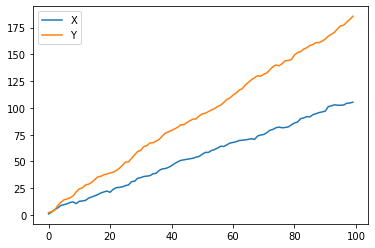

In [7]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot();

print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Augmented Engle-Granger two-step cointegration test p-value: ' + str(pvalue))
print("\n")

df_diverging = pd.DataFrame({'x':X_diverging, 'y':Y_diverging})
jres = coint_johansen(df_diverging, 1, 0)

print('Cointegration Johansen test Trace Statistic & Critical Values:')
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)
print("\n")
print('Cointegration Johansen test Eigen Statistic & Critical Values:')
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

### Cointegration Without Correlation
An example of two assets that have high levels of cointegration due to mean reversion as shown with a normally distributed series and square wave.

Correlation: -0.04262357720529404
Augmented Engle-Granger two-step cointegration test p-value: 8.333306298591733e-29
Cointegration Johansen test Trace Statistic & Critical Values:
[733.63164098   9.34873426]
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Cointegration Johansen test Eigen Statistic & Critical Values:
[724.28290672   9.34873426]
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


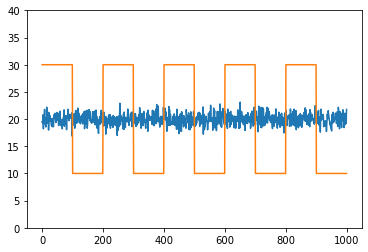

In [8]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10
Y2.plot()
Y3.plot()
plt.ylim([0, 40]);

# correlation is nearly zero
print('Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print('Augmented Engle-Granger two-step cointegration test p-value: ' + str(pvalue))


df_coint = pd.DataFrame({'x':Y2, 'y':Y3})
jres = coint_johansen(df_coint, 1, 0)

print('Cointegration Johansen test Trace Statistic & Critical Values:')
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)
print("\n")
print('Cointegration Johansen test Eigen Statistic & Critical Values:')
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

### High Correlation and Cointegration
An example of two assets that have high levels of cointegration and correlation with the long run expected value of spread between the two cointegrated time series converging around the mean. These example assets demonstrate a strong candidate for implementing a pairs trading strategy.

Correlation: 0.977439900338213
Augmented Engle-Granger two-step cointegration test p-value: 2.8020581145141864e-14
Cointegration Johansen test Trace Statistic & Critical Values:
[72.50863384  3.79762084]
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Cointegration Johansen test Eigen Statistic & Critical Values:
[68.711013    3.79762084]
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


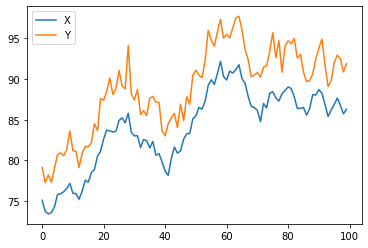

In [9]:
X_returns = np.random.normal(0, 1, 100) # Generates simulated daily returns
X = pd.Series(np.cumsum(X_returns), name='X') + 75
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot();
print('Correlation: ' + str(X.corr(Y)))
score, pvalue, _ = coint(X,Y)
print('Augmented Engle-Granger two-step cointegration test p-value: ' + str(pvalue))


df_coint = pd.DataFrame({'x':X, 'y':Y})
jres = coint_johansen(df_coint, 1, 0)

print('Cointegration Johansen test Trace Statistic & Critical Values:')
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)
print("\n")
print('Cointegration Johansen test Eigen Statistic & Critical Values:')
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

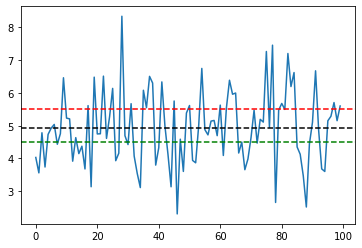

In [10]:
(Y-X).plot() # Plot the spread
plt.axhline((Y-X).mean(), color='black', linestyle='--') # Add the mean
plt.axhline(5.5, color='red', linestyle='--') 
plt.axhline(4.5, color='green', linestyle='--')

ADA-USD  ALGO-USD  AUDUSD=X  AVAX-USD   BNB-USD   BTC-USD  \
ADA-USD    1.000000  0.752776 -0.080030  0.737614  0.748406  0.761955   
ALGO-USD   0.752776  1.000000 -0.109260  0.722649  0.725817  0.704652   
AUDUSD=X  -0.080030 -0.109260  1.000000 -0.105368 -0.107512 -0.084036   
AVAX-USD   0.737614  0.722649 -0.105368  1.000000  0.742364  0.707388   
BNB-USD    0.748406  0.725817 -0.107512  0.742364  1.000000  0.788817   
BTC-USD    0.761955  0.704652 -0.084036  0.707388  0.788817  1.000000   
CAD=X      0.076189  0.092766 -0.794906  0.090880  0.099152  0.047633   
CHF=X      0.046497  0.048247 -0.625545  0.018897  0.046421  0.027001   
CNY=X     -0.025860 -0.045261 -0.450031 -0.008108  0.002783 -0.049982   
DOGE-USD   0.673369  0.613671 -0.071637  0.609747  0.670598  0.675809   
ETH-USD    0.777134  0.750993 -0.092890  0.763624  0.819676  0.882746   
EURUSD=X  -0.013132 -0.038385  0.659211 -0.030229 -0.064048 -0.003768   
GBPUSD=X  -0.063606 -0.110931  0.724917 -0.099640 -0.105196 -0.066277   
JPY=X      0.017947  0.010914 -0.433727  0.005678  0.029506  0.025909   
LINK-USD   0.780150  0.761787 -0.118718  0.734659  0.748839  0.748668   
LUNA1-USD  0.149299  0.166927  0.032965  0.168589  0.112609  0.104681   
MATIC-USD  0.737682  0.727805 -0.101976  0.740724  0.755588  0.740275   
SHIB-USD   0.439789  0.399571  0.001076  0.368762  0.463794  0.485965   
SOL1-USD   0.175914  0.212141  0.086805  0.178844  0.203661  0.196342   
SUSHI-USD  0.713653  0.693057 -0.066369  0.666397  0.703045  0.674733   
USDC-USD   0.065517  0.040196 -0.005688  0.071293  0.043379  0.052527   
USDT-USD   0.058040  0.082384 -0.002852  0.131781  0.078417  0.036939   
XRP-USD    0.753283  0.720014 -0.117681  0.718517  0.715557  0.721550   

              CAD=X     CHF=X     CNY=X  DOGE-USD  ...     JPY=X  LINK-USD  \
ADA-USD    0.076189  0.046497 -0.025860  0.673369  ...  0.017947  0.780150   
ALGO-USD   0.092766  0.048247 -0.045261  0.613671  ...  0.010914  0.761787   
AUDUSD=X  -0.794906 -0.625545 -0.450031 -0.071637  ... -0.433727 -0.118718   
AVAX-USD   0.090880  0.018897 -0.008108  0.609747  ...  0.005678  0.734659   
BNB-USD    0.099152  0.046421  0.002783  0.670598  ...  0.029506  0.748839   
BTC-USD    0.047633  0.027001 -0.049982  0.675809  ...  0.025909  0.748668   
CAD=X      1.000000  0.530871  0.332154  0.077015  ...  0.310627  0.069552   
CHF=X      0.530871  1.000000  0.422448  0.039630  ...  0.529270  0.072996   
CNY=X      0.332154  0.422448  1.000000  0.019872  ...  0.343721 -0.011648   
DOGE-USD   0.077015  0.039630  0.019872  1.000000  ... -0.007086  0.620057   
ETH-USD    0.086021  0.027707 -0.025417  0.698970  ...  0.020581  0.795022   
EURUSD=X  -0.610316 -0.730011 -0.442533 -0.010040  ... -0.421429 -0.053657   
GBPUSD=X  -0.624914 -0.611803 -0.424261 -0.055723  ... -0.461876 -0.125119   
JPY=X      0.310627  0.529270  0.343721 -0.007086  ...  1.000000  0.036254   
LINK-USD   0.069552  0.072996 -0.011648  0.620057  ...  0.036254  1.000000   
LUNA1-USD  0.008631 -0.036104 -0.049318  0.131565  ...  0.074130  0.135952   
MATIC-USD  0.097165  0.036216 -0.036749  0.618871  ...  0.013285  0.747791   
SHIB-USD   0.017016  0.022816  0.000038  0.505156  ... -0.005816  0.421369   
SOL1-USD  -0.052355 -0.092582 -0.079955  0.138540  ... -0.029993  0.173830   
SUSHI-USD  0.057040  0.039589 -0.028469  0.610740  ...  0.031168  0.715811   
USDC-USD  -0.015420 -0.026250 -0.010157  0.026041  ... -0.011583  0.044009   
USDT-USD   0.017891 -0.039237  0.026041  0.098820  ...  0.008858  0.069560   
XRP-USD    0.106556  0.045538 -0.011429  0.650999  ...  0.013970  0.725487   

           LUNA1-USD  MATIC-USD  SHIB-USD  SOL1-USD  SUSHI-USD  USDC-USD  \
ADA-USD     0.149299   0.737682  0.439789  0.175914   0.713653  0.065517   
ALGO-USD    0.166927   0.727805  0.399571  0.212141   0.693057  0.040196   
AUDUSD=X    0.032965  -0.101976  0.001076  0.086805  -0.066369 -0.005688   
AVAX-USD    0.168589   0.740724  0.368762  0.178844   0.666397  0.071293   
BNB-US

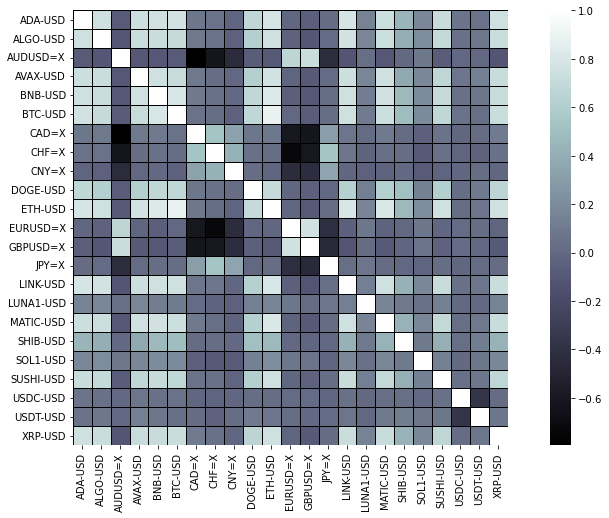

In [11]:
plt.figure(figsize = (15,8))
sns.heatmap(log_returns.corr(), cmap = "bone", linewidths = .7, linecolor = "black", square = True)
log_returns.corr()

In [13]:
high_corr_assets = set()
corr_matrix = log_returns.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.7:
            asset1 = corr_matrix.columns[i]
            asset2 = corr_matrix.columns[j]
            high_corr_assets.add((asset1, asset2))
print(high_corr_assets)


{('GBPUSD=X', 'AUDUSD=X'), ('BTC-USD', 'ALGO-USD'), ('MATIC-USD', 'AVAX-USD'), ('LINK-USD', 'ADA-USD'), ('LINK-USD', 'ALGO-USD'), ('ETH-USD', 'ADA-USD'), ('XRP-USD', 'BNB-USD'), ('MATIC-USD', 'LINK-USD'), ('ETH-USD', 'ALGO-USD'), ('XRP-USD', 'AVAX-USD'), ('MATIC-USD', 'ETH-USD'), ('XRP-USD', 'LINK-USD'), ('XRP-USD', 'ETH-USD'), ('GBPUSD=X', 'EURUSD=X'), ('BNB-USD', 'AVAX-USD'), ('MATIC-USD', 'BTC-USD'), ('SUSHI-USD', 'BNB-USD'), ('MATIC-USD', 'ADA-USD'), ('MATIC-USD', 'ALGO-USD'), ('XRP-USD', 'BTC-USD'), ('BTC-USD', 'BNB-USD'), ('LINK-USD', 'BNB-USD'), ('BTC-USD', 'ADA-USD'), ('BTC-USD', 'AVAX-USD'), ('SUSHI-USD', 'LINK-USD'), ('XRP-USD', 'ADA-USD'), ('XRP-USD', 'MATIC-USD'), ('LINK-USD', 'AVAX-USD'), ('SUSHI-USD', 'ETH-USD'), ('ETH-USD', 'BNB-USD'), ('XRP-USD', 'ALGO-USD'), ('ETH-USD', 'AVAX-USD'), ('LINK-USD', 'ETH-USD'), ('BNB-USD', 'ALGO-USD'), ('BNB-USD', 'ADA-USD'), ('AVAX-USD', 'ADA-USD'), ('AVAX-USD', 'ALGO-USD'), ('SUSHI-USD', 'ADA-USD'), ('LINK-USD', 'BTC-USD'), ('ALGO-USD', 

In [19]:
prices = assetsDF.pivot(index='Date', columns='Symbol', values='Close')
prices = prices.dropna()

for asset_pair in high_corr_assets:
    asset1 = asset_pair[0]
    asset2 = asset_pair[1]
    prices1 = prices[asset1]
    prices2 = prices[asset2]
    if prices1.isnull().values.any() or prices2.isnull().values.any():
        print(f"NaN values found for {asset1} or {asset2}, skipping cointegration test.")
        continue
    if np.isinf(prices1).any() or np.isinf(prices2).any():
        print(f"Infinite values found for {asset1} or {asset2}, skipping cointegration test.")
        continue
    results = sm.tsa.stattools.coint(prices1, prices2)
    print(f"{asset1} and {asset2}:")
    print(f"Test statistic: {results[0]}")
    print(f"P-value: {results[1]}")
    print(f"Critical values: {results[2]}")
    print("--------------------------")


GBPUSD=X and AUDUSD=X:
Test statistic: -2.6924728052528804
P-value: 0.20229756115889225
Critical values: [-3.93685701 -3.35852052 -3.05996506]
--------------------------
BTC-USD and ALGO-USD:
Test statistic: -2.721188976907805
P-value: 0.1920505635991434
Critical values: [-3.93685701 -3.35852052 -3.05996506]
--------------------------
MATIC-USD and AVAX-USD:
Test statistic: -3.85153984766343
P-value: 0.01155584039111314
Critical values: [-3.93685701 -3.35852052 -3.05996506]
--------------------------
LINK-USD and ADA-USD:
Test statistic: -2.9579914214569545
P-value: 0.12053166697812795
Critical values: [-3.93685701 -3.35852052 -3.05996506]
--------------------------
LINK-USD and ALGO-USD:
Test statistic: -4.646636306648954
P-value: 0.0006960455471528946
Critical values: [-3.93685701 -3.35852052 -3.05996506]
--------------------------
ETH-USD and ADA-USD:
Test statistic: -3.1911068221137855
P-value: 0.07142766814529582
Critical values: [-3.93685701 -3.35852052 -3.05996506]
-------------

In [22]:
from itertools import combinations

# Find all possible pairs of assets
all_assets = assetsDF['Symbol'].unique()
all_asset_pairs = list(combinations(all_assets, 2))

# Find pairs with high cointegration
high_corr_assets = []
for asset_pair in all_asset_pairs:
    asset1 = asset_pair[0]
    asset2 = asset_pair[1]
    prices1 = prices[asset1]
    prices2 = prices[asset2]
    results = sm.tsa.stattools.coint(prices1, prices2)
    if results[1] < 0.05:
        high_corr_assets.append(asset_pair)



[('BTC-USD', 'ETH-USD'),
 ('BTC-USD', 'USDT-USD'),
 ('BTC-USD', 'BNB-USD'),
 ('BTC-USD', 'USDC-USD'),
 ('BTC-USD', 'XRP-USD'),
 ('BTC-USD', 'SOL1-USD'),
 ('BTC-USD', 'LUNA1-USD'),
 ('BTC-USD', 'DOGE-USD'),
 ('BTC-USD', 'SHIB-USD'),
 ('BTC-USD', 'ADA-USD'),
 ('BTC-USD', 'LINK-USD'),
 ('BTC-USD', 'AVAX-USD'),
 ('BTC-USD', 'MATIC-USD'),
 ('BTC-USD', 'SUSHI-USD'),
 ('BTC-USD', 'ALGO-USD'),
 ('BTC-USD', 'EURUSD=X'),
 ('BTC-USD', 'GBPUSD=X'),
 ('BTC-USD', 'JPY=X'),
 ('BTC-USD', 'AUDUSD=X'),
 ('BTC-USD', 'CAD=X'),
 ('BTC-USD', 'CHF=X'),
 ('BTC-USD', 'CNY=X'),
 ('ETH-USD', 'USDT-USD'),
 ('ETH-USD', 'BNB-USD'),
 ('ETH-USD', 'USDC-USD'),
 ('ETH-USD', 'XRP-USD'),
 ('ETH-USD', 'SOL1-USD'),
 ('ETH-USD', 'LUNA1-USD'),
 ('ETH-USD', 'DOGE-USD'),
 ('ETH-USD', 'SHIB-USD'),
 ('ETH-USD', 'ADA-USD'),
 ('ETH-USD', 'LINK-USD'),
 ('ETH-USD', 'AVAX-USD'),
 ('ETH-USD', 'MATIC-USD'),
 ('ETH-USD', 'SUSHI-USD'),
 ('ETH-USD', 'ALGO-USD'),
 ('ETH-USD', 'EURUSD=X'),
 ('ETH-USD', 'GBPUSD=X'),
 ('ETH-USD', 'JPY=X'),
 (